# Guided Cost Learning MaxEnt Inverse RL in CartPole Environment

## Setup

### Installations

In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

!wget http://www.atarimania.com/roms/Roms.rar
!mkdir /content/ROM/
!unrar e /content/Roms.rar /content/ROM/
!python -m atari_py.import_roms /content/ROM/

### Imports

In [ ]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm.notebook import tqdm
from IPython.display import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

### Params

In [ ]:
seed = 18095048
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

### Gym render

In [ ]:
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

In [ ]:
display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment 
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

## Utils

In [ ]:
def get_cumulative_rewards(rewards, gamma=0.99):
    G = np.zeros_like(rewards, dtype=float)
    G[-1] = rewards[-1]
    for idx in range(-2, -len(rewards)-1, -1):
        G[idx] = rewards[idx] + gamma * G[idx+1]
    return G


def to_one_hot(y_tensor, ndims):
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    y_one_hot = torch.zeros(
        y_tensor.size()[0], ndims).scatter_(1, y_tensor, 1)
    return y_one_hot

## Generating Expert

### Policy Gradient Model

In [ ]:
class PG(nn.Module):
    def __init__(self, state_shape, n_actions):
        
        super().__init__()
        self.state_shape = state_shape
        self.n_actions = n_actions
        self.model = nn.Sequential(
            nn.Linear(in_features = state_shape[0], out_features = 128),
            nn.ReLU(),
            nn.Linear(in_features = 128 , out_features = 64),
            nn.ReLU(),
            nn.Linear(in_features = 64 , out_features = self.n_actions)
        )
        self.optimizer = torch.optim.Adam(self.model.parameters(), 1e-3)
    def forward(self, x):
        logits = self.model(x)
        return logits
    
    def predict_probs(self, states):
        states = torch.FloatTensor(states)
        logits = self.model(states).detach()
        probs = F.softmax(logits, dim = -1).numpy()
        # print(states, logits, probs)
        return probs
    
    def generate_session(self, env, t_max=1000):
        states, traj_probs, actions, rewards = [], [], [], []
        s = env.reset()
        q_t = 1.0
        for t in range(t_max):
            action_probs = self.predict_probs(np.array([s]))[0]
            a = np.random.choice(self.n_actions,  p = action_probs)
            new_s, r, done, info = env.step(a)
            
            q_t *= action_probs[a]

            states.append(s)
            traj_probs.append(q_t)
            actions.append(a)
            rewards.append(r)

            s = new_s
            if done:
                break

        return states, actions, rewards

    def _get_cumulative_rewards(self, rewards, gamma=0.99):
        G = np.zeros_like(rewards, dtype = float)
        G[-1] = rewards[-1]
        for idx in range(-2, -len(rewards)-1, -1):
            G[idx] = rewards[idx] + gamma * G[idx+1]
        return G

    def _to_one_hot(self, y_tensor, ndims):
        y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
        y_one_hot = torch.zeros(
            y_tensor.size()[0], ndims).scatter_(1, y_tensor, 1)
        return y_one_hot

    def train_on_env(self, env, gamma=0.99, entropy_coef=1e-2):
        states, actions, rewards = self.generate_session(env)
        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int32)
        cumulative_returns = np.array(self._get_cumulative_rewards(rewards, gamma))
        cumulative_returns = torch.tensor(cumulative_returns, dtype=torch.float32)

        logits = self.model(states)
        probs = nn.functional.softmax(logits, -1)
        log_probs = nn.functional.log_softmax(logits, -1)

        log_probs_for_actions = torch.sum(
            log_probs * self._to_one_hot(actions, env.action_space.n), dim=1)
    
        entropy = -torch.mean(torch.sum(probs*log_probs), dim = -1 )
        loss = -torch.mean(log_probs_for_actions*cumulative_returns -entropy*entropy_coef)

        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        return np.sum(rewards)

### Expert Training

In [ ]:
env_name = 'CartPole-v1'
env = gym.make(env_name).unwrapped

if seed is not None:
    env.seed(seed)
state = env.reset()

n_actions = env.action_space.n
state_shape = env.observation_space.shape

# initializing a model
model = PG(state_shape, n_actions)

mean_rewards = []
for i in range(100):
    rewards = [model.train_on_env(env) for _ in range(100)] 
    mean_rewards.append(np.mean(rewards))
    if i % 5:
        print("mean reward:%.3f" % (np.mean(rewards)))
        plt.figure(figsize=[9, 6])
        plt.title("Mean reward per 100 games")
        plt.plot(mean_rewards)
        plt.grid()
        # plt.show()
        plt.savefig('PG_learning_curve.png')
        plt.close()
    
    if np.mean(rewards) > 500:
        print("TRAINED!")
        break

torch.save(model, "pg.model")
#model.load("experts/saved_expert/pg.model")

num_expert = 100

expert_samples = np.array([model.generate_session(env) for i in range(num_expert)])
np.save('pg_cartpole', expert_samples)

mean reward:50.990
mean reward:125.530
mean reward:170.420
mean reward:56.430
mean reward:121.220
mean reward:505.700
TRAINED!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


### Performance Plots

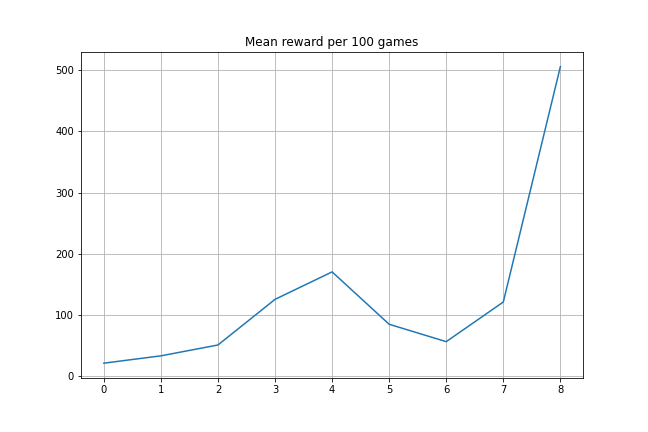

In [ ]:
Image('PG_learning_curve.png')

## Cost Model

In [ ]:
class CostNN(nn.Module):
    def __init__(
        self, 
        state_dim,
        hidden_dim1 = 128, 
        out_features = 1, 
    ):
        super(CostNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, out_features),
        )
    def forward(self, x):
        return self.net(x)

## Guided Cost Model Training

In [ ]:
# ENV SETUP
env_name = 'CartPole-v0'
env = gym.make(env_name).unwrapped
env = wrap_env(env)
if seed is not None:
    env.seed(seed)
n_actions = env.action_space.n
state_shape = env.observation_space.shape
state = env.reset()

# LOADING EXPERT/DEMO SAMPLES
demo_trajs = np.load('pg_cartpole.npy', allow_pickle=True)
print(len(demo_trajs))

# INITILIZING POLICY AND REWARD FUNCTION
policy = PG(state_shape, n_actions)
cost_f = CostNN(state_shape[0] + 1)
policy_optimizer = torch.optim.Adam(policy.parameters(), 1e-2)
cost_optimizer = torch.optim.Adam(cost_f.parameters(), 1e-2, weight_decay=1e-4)

mean_rewards = []
mean_costs = []
mean_loss_rew = []
EPISODES_TO_PLAY = 1
REWARD_FUNCTION_UPDATE = 10
DEMO_BATCH = 100
sample_trajs = []

D_demo, D_samp = np.array([]), np.array([])

# CONVERTS TRAJ LIST TO STEP LIST
def preprocess_traj(traj_list, step_list, is_Demo = False):
    step_list = step_list.tolist()
    for traj in traj_list:
        states = np.array(traj[0])
        if is_Demo:
            probs = np.ones((states.shape[0], 1))
        else:
            probs = np.array(traj[1]).reshape(-1, 1)
        actions = np.array(traj[2]).reshape(-1, 1)
        x = np.concatenate((states, probs, actions), axis=1)
        step_list.extend(x)
    return np.array(step_list)

D_demo = preprocess_traj(demo_trajs, D_demo, is_Demo=True)
return_list, sum_of_cost_list = [], []

for i in tqdm(range(1000)):
    trajs = [policy.generate_session(env) for _ in range(EPISODES_TO_PLAY)]
    sample_trajs = trajs + sample_trajs
    D_samp = preprocess_traj(trajs, D_samp)

    # UPDATING REWARD FUNCTION (TAKES IN D_samp, D_demo)
    loss_rew = []
    for _ in range(REWARD_FUNCTION_UPDATE):
        selected_samp = np.random.choice(len(D_samp), DEMO_BATCH)
        selected_demo = np.random.choice(len(D_demo), DEMO_BATCH)

        D_s_samp = D_samp[selected_samp]
        D_s_demo = D_demo[selected_demo]

        #D̂ samp ← D̂ demo ∪ D̂ samp
        D_s_samp = np.concatenate((D_s_demo, D_s_samp), axis = 0)

        states, probs, actions = D_s_samp[:,:-2], D_s_samp[:,-2], D_s_samp[:,-1]
        states_expert, actions_expert = D_s_demo[:,:-2], D_s_demo[:,-1]

        # Reducing from float64 to float32 for making computaton faster
        states = torch.tensor(states, dtype=torch.float32)
        probs = torch.tensor(probs, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.float32)
        states_expert = torch.tensor(states_expert, dtype=torch.float32)
        actions_expert = torch.tensor(actions_expert, dtype=torch.float32)

        costs_samp = cost_f(torch.cat((states, actions.reshape(-1, 1)), dim=-1))
        costs_demo = cost_f(torch.cat((states_expert, actions_expert.reshape(-1, 1)), dim=-1))

        # LOSS CALCULATION FOR IOC (COST FUNCTION)
        loss_IOC = torch.mean(costs_demo) + \
                torch.log(torch.mean(torch.exp(-costs_samp)/(probs+1e-7)))
        # UPDATING THE COST FUNCTION
        cost_optimizer.zero_grad()
        loss_IOC.backward()
        cost_optimizer.step()

        loss_rew.append(loss_IOC.detach())

    for traj in trajs:
        states, actions, rewards = traj
        
        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.float32)
            
        costs = cost_f(torch.cat((states, actions.reshape(-1, 1)), dim=-1)).detach().numpy()
        cumulative_returns = np.array(get_cumulative_rewards(-costs, 0.99))
        cumulative_returns = torch.tensor(cumulative_returns, dtype=torch.float32)

        logits = policy(states)
        probs = nn.functional.softmax(logits, -1)
        log_probs = nn.functional.log_softmax(logits, -1)

        log_probs_for_actions = torch.sum(
            log_probs * to_one_hot(actions, env.action_space.n), dim=1)
    
        entropy = -torch.mean(torch.sum(probs*log_probs), dim = -1 )
        loss = -torch.mean(log_probs_for_actions*cumulative_returns -entropy*1e-2) 

        # UPDATING THE POLICY NETWORK
        policy_optimizer.zero_grad()
        loss.backward()
        policy_optimizer.step()

    returns = sum(rewards)
    sum_of_cost = np.sum(costs)
    return_list.append(returns)
    sum_of_cost_list.append(sum_of_cost)

    mean_rewards.append(np.mean(return_list))
    mean_costs.append(np.mean(sum_of_cost_list))
    mean_loss_rew.append(np.mean(loss_rew))

    # PLOTTING PERFORMANCE
    if i % 10 == 0:
        # clear_output(True)
        print(f"mean reward:{np.mean(return_list)} loss: {loss_IOC}")

        plt.figure(figsize=[16, 12])
        plt.subplot(2, 2, 1)
        plt.title(f"Mean reward per {EPISODES_TO_PLAY} games")
        plt.plot(mean_rewards)
        plt.grid()

        plt.subplot(2, 2, 2)
        plt.title(f"Mean cost per {EPISODES_TO_PLAY} games")
        plt.plot(mean_costs)
        plt.grid()

        plt.subplot(2, 2, 3)
        plt.title(f"Mean loss per {REWARD_FUNCTION_UPDATE} batches")
        plt.plot(mean_loss_rew)
        plt.grid()

        # plt.show()
        plt.savefig('GCL_learning_curve.png')
        plt.close()

    if np.mean(return_list) > 500:
        break

100


  0%|          | 0/1000 [00:00<?, ?it/s]

mean reward:23.0 loss: 14.451787948608398
mean reward:14.545454545454545 loss: 14.190523147583008
mean reward:14.666666666666666 loss: 14.366945266723633
mean reward:15.838709677419354 loss: 14.19987678527832
mean reward:16.75609756097561 loss: 14.409577369689941
mean reward:19.03921568627451 loss: 14.387279510498047
mean reward:18.983606557377048 loss: 14.328646659851074
mean reward:18.070422535211268 loss: 14.400044441223145
mean reward:17.19753086419753 loss: 14.423482894897461
mean reward:17.0 loss: 14.416093826293945
mean reward:16.673267326732674 loss: 14.520042419433594
mean reward:16.28828828828829 loss: 14.41466999053955
mean reward:16.41322314049587 loss: 14.371374130249023
mean reward:16.610687022900763 loss: 14.456669807434082
mean reward:16.645390070921987 loss: 14.48792552947998
mean reward:16.75496688741722 loss: 14.294782638549805
mean reward:16.795031055900623 loss: 14.30284309387207
mean reward:16.923976608187136 loss: 14.252449989318848
mean reward:16.895027624309392

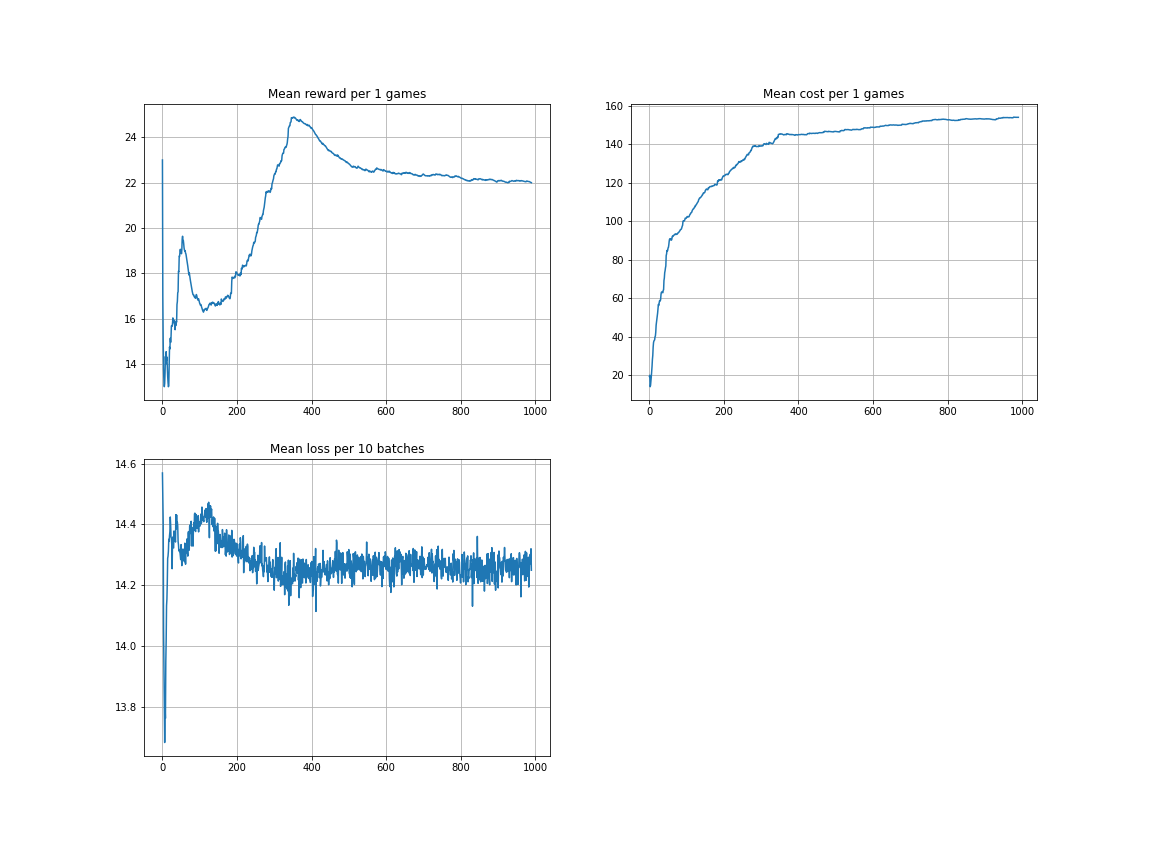

In [ ]:
Image('GCL_learning_curve.png')

In [ ]:
show_video()